In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

In [2]:
study_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\1_M1_V1"
data_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\1_M1_V1\data\json"
param_dir = r"E:\pirate_fmri\Analysis\data\Exp2_pilots\1_M1_V1\data\param"

## compute bonus for payment

In [41]:
dataset = []
for fn in os.listdir(data_dir):
    with open(os.path.join(data_dir,fn)) as f:
        dataset.append(json.load(f))

bonus_filepath=os.path.join(
    study_dir,
    "bonus.csv"
)
bonus_df = pd.DataFrame(
    np.vstack([[data["edata"]["expt_turker"] for data in dataset],
[data["edata"]["bonus_pound"] for data in dataset],
[data["edata"]["expt_subject"] for data in dataset],
[np.unique(data["sdata"]["expt_session"])[0] for data in dataset]]).T,
columns=["prolificid","bonus","expt_id","session"]
)
(bonus_df[~bonus_df.prolificid.str.contains("test")]).to_csv(bonus_filepath)



check one example dataset

In [7]:
data = dataset[5]
print(data.keys())
print(f"edata keys: {data['edata'].keys()}")
for k,v in data["sdata"].items():
    print(f"{k}: {len(v)}")
experiment_df = pd.DataFrame(data["sdata"])
print(experiment_df.head())
data["ddata"]

dict_keys(['sdata', 'edata', 'ddata'])
edata keys: dict_keys(['expt_subject', 'expt_sex', 'expt_age', 'expt_task', 'expt_turker', 'bonus', 'exp_starttime', 'ins_starttime', 'ins_duration', 'tracker_pracCacc', 'bonus_pound', 'exp_finishtime'])
expt_session: 776
expt_index: 776
expt_trial: 776
expt_block: 776
expt_task: 776
expt_cond: 776
expt_coordsys: 776
expt_curricula: 776
expt_map: 776
stim_id: 776
stim_x: 776
stim_y: 776
stim_img: 776
start_x: 776
start_y: 776
start_sx: 776
start_sy: 776
distactorside: 776
distractor_x: 776
distractor_y: 776
ctrl_fb: 776
ctrl_ept: 776
time_fixation: 776
time_cue: 776
time_arena: 776
time_response: 776
resp_x: 776
resp_y: 776
resp_sx: 776
resp_sy: 776
resp_dist: 776
resp_choice: 776
resp_rt: 776
resp_acclvl: 776
resp_correct: 776
   expt_session  expt_index  expt_trial  expt_block  expt_task  expt_cond  \
0             1           0           0          36          0          4   
1             1           1           1          36          0       

{'expbreak': 'Yes, definitely enough quantity of breaks, however as the experiment itself felt time pressured, i felt under pressure to not use as much of the break as possbile',
 'ruleverbal': 'yes, after the first day i started to realise that some symbols relate to the vertical and some to the horizontal',
 'challenge': 'the time pressures, especially in the choice of colour, i definitely struggled with getting this doen in the short time available',
 'focus': 'yes, the breaks were sufficient and i found i was able to fully concentrate',
 'strategy': 'once i was aware of the pattern, i assigned each symbol a letter, eg S,D,E,N,Y etc, and said that in my head, then i started to be able to picture in my mind where to put my mouse and click',
 'toolverbal': 'No tools, only repeated the symbols in my mind to solidify where i needed to go',
 'feedback': 'no',
 'cluster': {'symID': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
  'init_sx': [82.717224663409,
   415.61401543297,
   47.578131782537,
   32

## check the bonus file to select participants who finished both days to get valid id

In [3]:
valid_exptid = ["7bt9uIz5G1aJ",
                "DMGY9zCfGDYx",
                "HgUrUWFTRiIE",
                "Ij4NO2rW8SbI",
                "jIb8kZKzSFNc",
                "jYuzKuOlKAV1",
                "lKo186FW3Hk0",
                "mSZwQS13pi4K",
                "NSnEI5v2eoeR",
                "TbSUHibinOv3"
                ]

## organize all the task data

In [43]:
dataset = []
data_dfs = []
for id in valid_exptid:
    data_files = [os.path.join(data_dir,f"cond4_{id}_session1.json"),os.path.join(data_dir,f"cond4_{id}_session2.json")]
    param_file = os.path.join(param_dir,f"param_{id}.json")
    subdfs = []
    for fn in data_files:
        with open(os.path.join(fn)) as f:
            data = json.load(f)
            dataset.append(data)
            subdfs.append(pd.DataFrame(data["sdata"]).assign(prolificid=data['edata']['expt_turker'],subid=id))
    subdf = pd.concat(subdfs).reset_index(drop=True)
    data_dfs.append(subdf)
    with open(param_file) as f:
            param = json.load(f)

org_data_dfs = []
for subdf in data_dfs:
    subdf["istraining"] = [np.logical_xor(x==0,y==0) for x,y in zip(subdf["stim_x"],subdf["stim_y"])] 
    ts_df_s1 = subdf[(subdf.ctrl_ept==1)&(subdf.expt_task==0)&(subdf.expt_session==0)].copy()
    ts_df_s2 = subdf[(subdf.ctrl_ept==1)&(subdf.expt_task==0)&(subdf.expt_session==1)].copy()
    stims = {"train":[[],[]],
                "test":[[],[]]}
    for b,b_df in ts_df_s1.groupby("expt_block"):
        if np.shape(b_df[b_df.istraining])[0]==8:
            stims["train"][0].append(np.unique(b_df[b_df.istraining].stim_id))
        elif np.shape(b_df[~b_df.istraining])[0]==8:
            stims["test"][0].append(np.unique(b_df[~b_df.istraining].stim_id))

    for b,b_df in ts_df_s2.groupby("expt_block"):
        if np.shape(b_df[b_df.istraining])[0]>0:
            stims["train"][1].append(np.unique(b_df[b_df.istraining].stim_id))
        if np.shape(b_df[~b_df.istraining])[0]>0:
            stims["test"][1].append(np.unique(b_df[~b_df.istraining].stim_id))    
            import itertools
    #if want to double check
    #np.all([np.array_equal(a1,a2) for a1,a2 in itertools.combinations(stims["test"][0],2)])
    #np.all([np.array_equal(a1,a2) for a1,a2 in itertools.combinations(stims["test"][1],2)])
    #np.all([np.array_equal(a1,a2) for a1,a2 in itertools.combinations(stims["train"][0],2)])

    trainid= np.unique(stims["train"][0])
    testid_in_s1 = np.unique(stims["test"][0])
    testid_in_s2 =  np.unique(stims["test"][1])[[(x not in testid_in_s1) for x in np.unique(stims["test"][1])]]
    group_name = np.array(["training","validation","test"])
    subdf["stim_group"] = [group_name[[x in trainid, x in testid_in_s1, x in testid_in_s2]][0] for x in subdf.stim_id]
    org_data_dfs.append(subdf)

org_data = pd.concat(org_data_dfs).reset_index(drop=True).fillna(value=np.nan)
print(org_data.dtypes)

bool2int_columns = ["ctrl_fb","ctrl_ept","istraining"]
for k in bool2int_columns:
    org_data[k] = org_data[k].astype(int)
print(org_data.dtypes)

org_data["resp_correct"] = org_data["resp_correct"].astype(int)

print(org_data.dtypes)
org_data.to_csv(os.path.join(study_dir,"task_data.csv"))

expt_session        int64
expt_index          int64
expt_trial          int64
expt_block          int64
expt_task           int64
expt_cond           int64
expt_coordsys       int64
expt_curricula      int64
expt_map            int64
stim_id             int64
stim_x            float64
stim_y            float64
stim_img           object
start_x           float64
start_y           float64
start_sx          float64
start_sy          float64
distactorside     float64
distractor_x      float64
distractor_y      float64
ctrl_fb              bool
ctrl_ept             bool
time_fixation       int64
time_cue            int64
time_arena          int64
time_response       int64
resp_x            float64
resp_y            float64
resp_sx           float64
resp_sy           float64
resp_dist         float64
resp_choice       float64
resp_rt             int64
resp_acclvl       float64
resp_correct       object
prolificid         object
subid              object
istraining           bool
stim_group  

### Plot basic summary statistics for checking

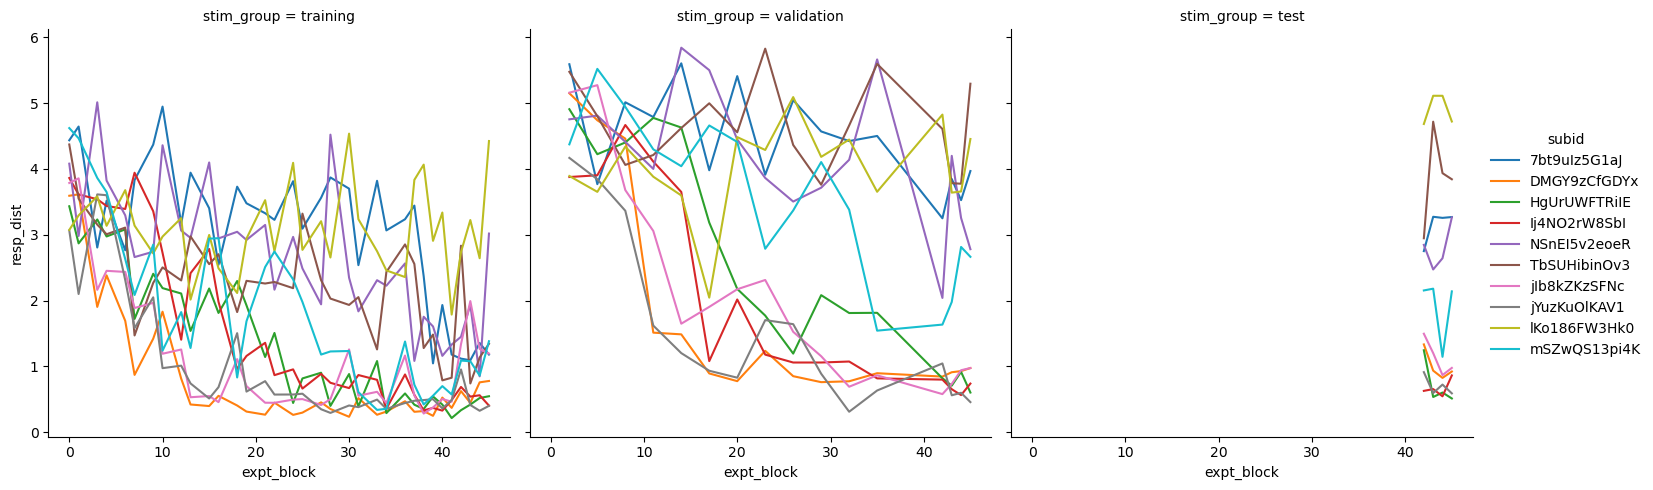

In [5]:
treasurehunt_df = org_data[org_data.expt_task==0].copy()
treasurehunt_sum_df = treasurehunt_df.groupby(["subid","expt_map","expt_session","expt_task","expt_block","stim_group"])[["resp_dist","resp_rt"]].mean().reset_index()
treasurehunt_sum_df.head(5)
sns.relplot(treasurehunt_sum_df,x="expt_block",y="resp_dist",hue="subid",col="stim_group",kind="line")


In [6]:
loc2AFC_df = org_data[org_data.expt_task==1].copy()
print(loc2AFC_df.columns)
loc2AFC_df.head(5)

Index(['expt_session', 'expt_index', 'expt_trial', 'expt_block', 'expt_task',
       'expt_cond', 'expt_coordsys', 'expt_curricula', 'expt_map', 'stim_id',
       'stim_x', 'stim_y', 'stim_img', 'start_x', 'start_y', 'start_sx',
       'start_sy', 'distactorside', 'distractor_x', 'distractor_y', 'ctrl_fb',
       'ctrl_ept', 'time_fixation', 'time_cue', 'time_arena', 'time_response',
       'resp_x', 'resp_y', 'resp_sx', 'resp_sy', 'resp_dist', 'resp_choice',
       'resp_rt', 'resp_acclvl', 'resp_correct', 'prolificid', 'subid',
       'istraining', 'stim_group'],
      dtype='object')


,expt_session,expt_index,expt_trial,expt_block,expt_task,expt_cond,expt_coordsys,expt_curricula,expt_map,stim_id,...,resp_sy,resp_dist,resp_choice,resp_rt,resp_acclvl,resp_correct,prolificid,subid,istraining,stim_group
452,1,152,0,46,1,4,0,2,0,23,...,NaN,NaN,NaN,1000,NaN,1,5d486babd7738b0019a27818,7bt9uIz5G1aJ,0,validation
453,1,153,1,46,1,4,0,2,0,0,...,NaN,NaN,0.0,868,NaN,1,5d486babd7738b0019a27818,7bt9uIz5G1aJ,0,validation
454,1,154,2,46,1,4,0,2,0,16,...,NaN,NaN,NaN,1014,NaN,1,5d486babd7738b0019a27818,7bt9uIz5G1aJ,0,validation
455,1,155,3,46,1,4,0,2,0,12,...,NaN,NaN,0.0,788,NaN,0,5d486babd7738b0019a27818,7bt9uIz5G1aJ,0,test
456,1,156,4,46,1,4,0,2,0,2,...,NaN,NaN,NaN,1014,NaN,0,5d486babd7738b0019a27818,7bt9uIz5G1aJ,1,training


In [7]:
print(f"dropped {((np.isnan(loc2AFC_df['resp_choice']).sum())/loc2AFC_df.shape[0])*100}% of trials")
loc2AFC_df = loc2AFC_df.dropna(subset=["resp_choice"])
loc2AFC_df["resp_correct"] = np.array(loc2AFC_df["resp_choice"] != loc2AFC_df["distactorside"])*1
loc2AFC_sum_df = loc2AFC_df.groupby(["subid","expt_map","stim_group","expt_session","expt_task","expt_block"])[["resp_rt","resp_correct"]].mean().reset_index()
loc2AFC_sum_df.head(5)

dropped 7.82051282051282% of trials


,subid,expt_map,stim_group,expt_session,expt_task,expt_block,resp_rt,resp_correct
0,7bt9uIz5G1aJ,0,test,1,1,46,719.000000,0.285714
1,7bt9uIz5G1aJ,0,test,1,1,47,732.666667,0.833333
2,7bt9uIz5G1aJ,0,test,1,1,48,845.750000,0.250000
3,7bt9uIz5G1aJ,0,test,1,1,49,836.000000,0.714286
4,7bt9uIz5G1aJ,0,test,1,1,50,706.000000,1.000000


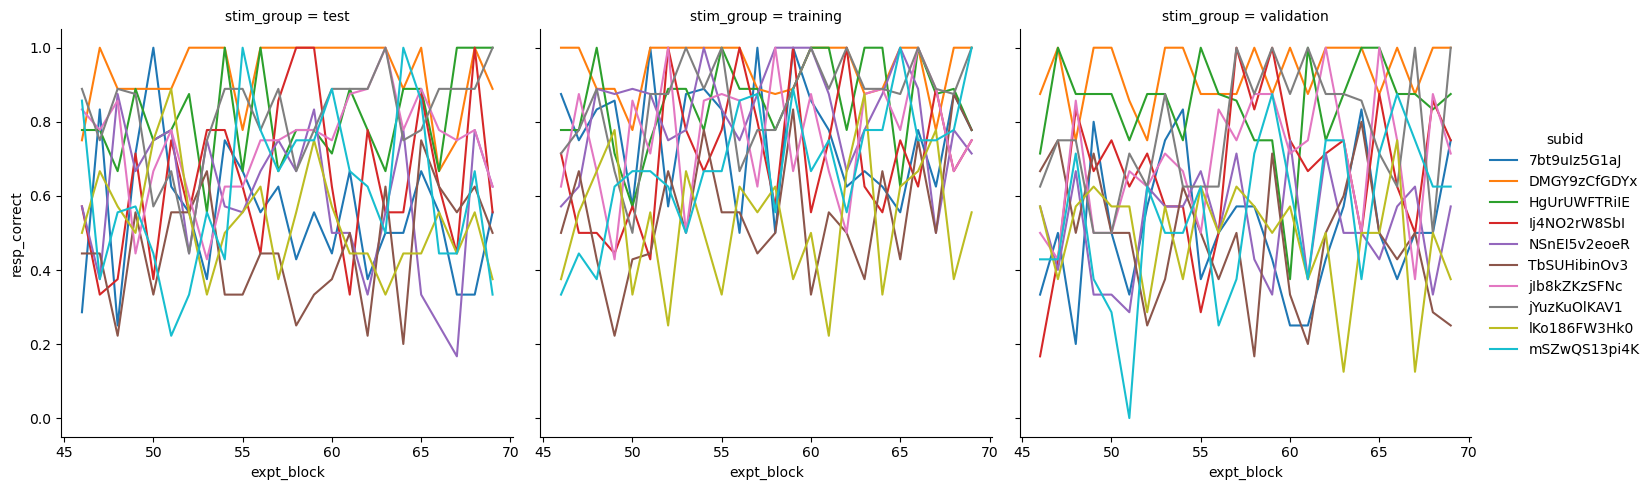

In [11]:
sns.relplot(loc2AFC_sum_df,x="expt_block",y="resp_correct",hue="subid",col="stim_group",kind="line")

## organize debrief data

In [4]:
dataset = []
cluster_data_dfs = []
debrief_data_dfs = []
for k,id in enumerate(valid_exptid):
    fn = os.path.join(data_dir,f"cond4_{id}_session2.json")
    param_file = os.path.join(param_dir,f"param_{id}.json")
    with open(fn) as f:
        data = json.load(f)
        dataset.append(data)
        cluster_task_data = data['ddata'].pop("cluster")
        cluster_data_dfs.append(pd.DataFrame(cluster_task_data).assign(prolificid=data['edata']['expt_turker'],subid=id))
        debrief_data_dfs.append(pd.DataFrame(data['ddata'],index=[k]).assign(prolificid=data['edata']['expt_turker'],subid=id))
    with open(param_file) as f:
        param = json.load(f)

In [9]:
param["stim_Lsymbols"] + param["stim_Rsymbols"]

['sr9', 'sr1', 'sr7', 'sr4', 'sr6', 'sr3', 'sr10', 'sr8', 'sr2', 'sr5']

In [46]:
cluster_df = pd.concat(cluster_data_dfs).reset_index(drop=True)
debrief_df = pd.concat(debrief_data_dfs).reset_index(drop=True)
cluster_df.to_csv(os.path.join(study_dir,"cluster_data.csv"))
debrief_df.to_csv(os.path.join(study_dir,"debrief_data.csv"))

In [10]:
pd.concat(cluster_data_dfs).reset_index(drop=True)

,symID,init_sx,init_sy,final_sx,final_sy,init_x,init_y,final_x,final_y,prolificid,subid
0,0,144.947966,232.902757,78.947966,252.902757,1.151095,1.866891,0.617761,2.028507,5d486babd7738b0019a27818,7bt9uIz5G1aJ
1,1,137.562698,184.130985,133.562698,184.130985,1.091416,1.472776,1.059093,1.472776,5d486babd7738b0019a27818,7bt9uIz5G1aJ
2,2,183.874325,156.231268,234.874325,310.231268,1.465651,1.247323,1.877772,2.491768,5d486babd7738b0019a27818,7bt9uIz5G1aJ
3,3,365.797107,173.441157,342.797107,179.441157,2.935734,1.386393,2.749876,1.434878,5d486babd7738b0019a27818,7bt9uIz5G1aJ
4,4,147.887125,218.439471,368.887125,93.439471,1.174845,1.750016,2.960704,0.739915,5d486babd7738b0019a27818,7bt9uIz5G1aJ
...,...,...,...,...,...,...,...,...,...,...,...
95,5,241.129446,68.203513,241.129446,40.203513,1.928319,0.535988,1.928319,0.309725,61603594da220b1a4dbac2ec,TbSUHibinOv3
96,6,343.388252,235.076144,242.388252,126.076144,2.754653,1.884454,1.938491,1.003646,61603594da220b1a4dbac2ec,TbSUHibinOv3
97,7,230.771908,204.085306,233.771908,196.085306,1.844621,1.634023,1.868864,1.569376,61603594da220b1a4dbac2ec,TbSUHibinOv3
98,8,459.784955,323.379687,240.784955,334.379687,3.695232,2.598018,1.925535,2.686907,61603594da220b1a4dbac2ec,TbSUHibinOv3
